### Task variant 20
* Classes count: $N = 4$
* Elements in class: $M = 536$
* Error min. $R1 = 0.49$ max. $R2 = 0.51$

In [1]:
N = 4
M = 536
R1 = 0.49
R2 = 0.51

DATA_FRAGMENTATION = 0.5
CLOUD_SHIFT = 0.556

GRAPH_POINT_SIZE = 30
GRAPH_POINT_ALPHA = 0.3

FIT_TIMES_TO_AVERAGE = 40

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from scipy.stats import norm

import time as t
import pprint as pp
from collections import defaultdict

sns.set(rc={'figure.figsize':(7.8, 5.51)})

#### Generating 2d Gaussian noise, $M$ points by 2 coordinates

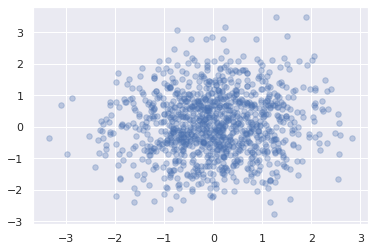

In [3]:
noise = np.random.randn(M * 2, 2) 
plt.scatter(noise[:,0], noise[:,1], s=GRAPH_POINT_SIZE, alpha=GRAPH_POINT_ALPHA)

#### Shifting noise a bit to create clouds

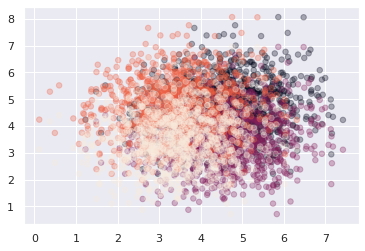

In [4]:
XY = np.vstack([
    noise + np.array([CLOUD_SHIFT, CLOUD_SHIFT]), 
    noise + np.array([CLOUD_SHIFT, -CLOUD_SHIFT]), 
    noise + np.array([-CLOUD_SHIFT, CLOUD_SHIFT]), 
    noise + np.array([-CLOUD_SHIFT, -CLOUD_SHIFT])
])

# To make sklearn classifiers work
XY += np.max(np.abs(XY))

annotations = [0] * M * 2 + [1] * M * 2 + [2] * M * 2 + [3] * M * 2

plt.scatter(XY[:,0], XY[:,1], c=annotations, s=GRAPH_POINT_SIZE, alpha=GRAPH_POINT_ALPHA)

In [5]:
for i in range(N):
    print(f"Cloud {i}:")
    print(f"Mean: {XY[i].mean()} \n Std: {XY[i].std()}\n Mean axis=0: {XY[i].mean(axis=0)}\n")

Cloud 0:
Mean: 4.332720109616923 
 Std: 1.4230011268539133
 Mean axis=0: 4.332720109616923

Cloud 1:
Mean: 4.470746316786629 
 Std: 1.0096989614264005
 Mean axis=0: 4.470746316786629

Cloud 2:
Mean: 4.729702167880109 
 Std: 0.5319719374113352
 Mean axis=0: 4.729702167880109

Cloud 3:
Mean: 4.7244917444614805 
 Std: 0.5808143493420106
 Mean axis=0: 4.7244917444614805



#### Shuffling data, generating training and testing sets 

In [6]:
data, labels = shuffle(XY, annotations)
labels = np.array(labels)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(data, labels, test_size=DATA_FRAGMENTATION) 

#### Custom NBC implementation

In [7]:
class CustomNBC(object):
    def __init__(self):
        pass
    
    def fit(self, data, labels):
        means = dict()
        stds = dict()
        
        label_set = set(labels)
        
        for label in label_set:
            filtered = data[labels == label]
            
            means[label] = np.mean(filtered, axis=0)
            stds[label] = np.std(filtered, axis=0)
        
        self.means = means
        self.stds = stds
        self.label_set = label_set


    def predict(self, data):
        means = self.means
        stds = self.stds
        label_set = self.label_set
        
        res = []
        
        for vec in data:
            # let's assume that vec's coords are independent
            
            best_prob = 0
            best_prob_label = None
        
            for label in label_set:
                label_mean = means[label]
                label_std = stds[label]
                
                prob = 1
                
                for coord_indx, coord in enumerate(vec):
                    # calculating ~prob. that *coord* is
                    # distributed by *label* norm. distrib.
                    loc = label_mean[coord_indx]
                    scale = label_std[coord_indx]
                    
                    # could replace with direct formula, but why?
                    # also could replace *norm* with othres distr-ns
                    coord_prob = norm.pdf(coord, loc=loc, scale=scale)
                    
                    prob *= coord_prob
                    
                if best_prob < prob:
                    best_prob = prob
                    best_prob_label = label
            
            res.append(best_prob_label)
        
        return np.array(res)

### Creating classifiers


In [8]:
models = [GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CustomNBC]

In [9]:
accuracies = dict()
confusion_matrices = dict()

times = defaultdict(list)

In [10]:
def evaluate(P, T):
    # P - predictions
    # T - targets
    # accuracy = correct predictions / all predictions
    accuracy = np.mean(P == T)
    return accuracy

for model in models:
    model_name = str(model.__name__)
    
    for _ in range(FIT_TIMES_TO_AVERAGE):
        clf = model()
        
        start = t.time()
        clf.fit(Xtrain, Ytrain)
        predictions = clf.predict(Xtest)
        end = t.time()
        
        times[model_name] += [end - start]
        
        accuracy = evaluate(predictions, Ytest)
        accuracies[model_name] = accuracy
        
        cf_matrix = confusion_matrix(predictions, Ytest)
        confusion_matrices[model_name] = cf_matrix

### Testting classifiers
#### Running time

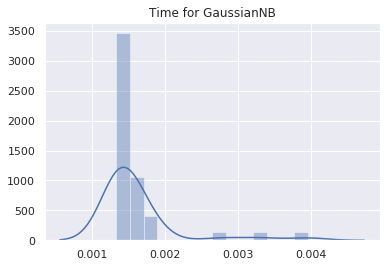

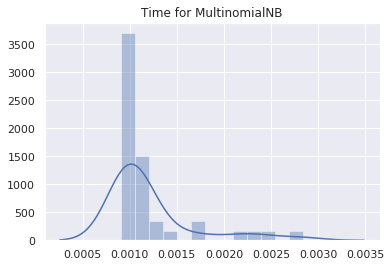

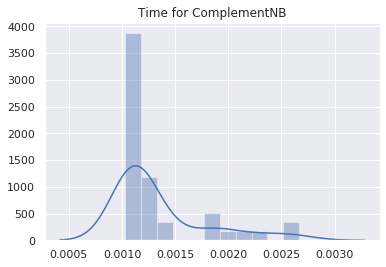

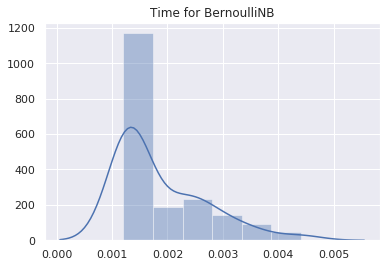

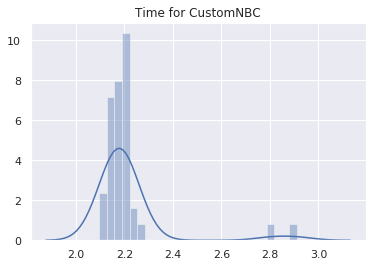

In [11]:
for model in models:
    model_name = str(model.__name__)
    time_data = np.array(times[model_name])
    
    sns.distplot(time_data).set_title(f'Time for {model_name}')
    plt.show()

#### Confusion matrices

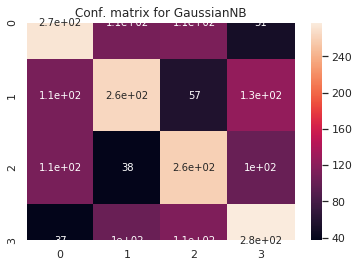

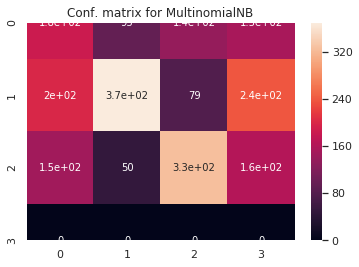

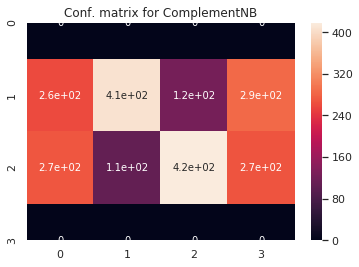

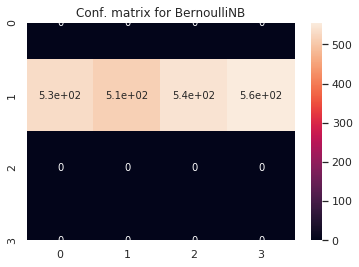

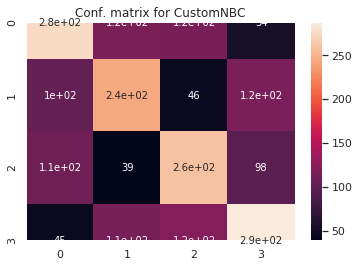

In [12]:
for model in models:
    model_name = str(model.__name__)
    cf_matrix = confusion_matrices[model_name]
    
    sns.heatmap(cf_matrix, annot=True).set_title(f'Conf. matrix for {model_name}')
    plt.show()

#### Finding the most accurate model

In [13]:
pp.pprint(accuracies)

print()
print(f'The most accurate model: {max(accuracies, key=accuracies.get)}')

{'BernoulliNB': 0.23973880597014927,
 'ComplementNB': 0.384794776119403,
 'CustomNBC': 0.4976679104477612,
 'GaussianNB': 0.5009328358208955,
 'MultinomialNB': 0.41091417910447764}

The most accurate model: GaussianNB


#### Finding the most stable model

In [14]:
min_std = np.inf
min_std_model = None

for model in models:
    model_name = str(model.__name__)
    time_data = np.array(times[model_name])
    
    time_data = time_data
    
    mean_time = time_data.mean()
    std_time  = time_data.std()
    
    if min_std > std_time:
        min_std = std_time
        min_std_model = model_name
    
    print(f'For model {model_name}: mean time {mean_time}; std. deviation {std_time}')

print()
print(f'The most stable model: {min_std_model}')

For model GaussianNB: mean time 0.0016055107116699219; std. deviation 0.000535938188135922
For model MultinomialNB: mean time 0.0012027382850646972; std. deviation 0.0004530961700806202
For model ComplementNB: mean time 0.0013407528400421142; std. deviation 0.00042864301907011683
For model BernoulliNB: mean time 0.001869499683380127; std. deviation 0.0007982628858496564
For model CustomNBC: mean time 2.212318021059036; std. deviation 0.15299880595083137

The most stable model: ComplementNB
